<a href="https://colab.research.google.com/github/intimanjunath/deep-learning-keras-hub-teachable-machine/blob/main/keras_hub_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EASY LEVEL

In [ ]:
!pip install tensorflow tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Load CIFAR-10 Dataset (instead of MNIST)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = x_train[:5000], y_train[:5000].squeeze()
x_test, y_test = x_test[:1000], y_test[:1000].squeeze()

print("Train shape:", x_train.shape, "Test shape:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Train shape: (5000, 32, 32, 3) Test shape: (1000, 32, 32, 3)


In [ ]:
#Preprocessing for MobileNetV2

def preprocess_cifar(image, label, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_cifar).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_cifar).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Define Model with Custom TF Hub Layer

class CustomHubLayer(tf.keras.layers.Layer):
    def __init__(self, url, trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.url = url
        self.trainable = trainable

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.url, trainable=self.trainable)
        super().build(input_shape)

    def call(self, inputs, training=False):
        return self.hub_layer(inputs)

mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [ ]:
#Build & Train Model

model_easy = tf.keras.Sequential([
    CustomHubLayer(mobilenet_url, trainable=False),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_easy.build((None, 224, 224, 3))
model_easy.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_easy.summary()
history_easy = model_easy.fit(train_ds, epochs=3, validation_data=test_ds)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_hub_layer (CustomHubLayer)    │ (None, 1001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          10,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,020 (39.14 KB)

 Trainable params: 10,020 (39.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5332 - loss: 1.5799 - val_accuracy: 0.7640 - val_loss: 0.7156
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8033 - loss: 0.5533 - val_accuracy: 0.7850 - val_loss: 0.6451
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8321 - loss: 0.4851 - val_accuracy: 0.7810 - val_loss: 0.6800


In [ ]:
#Evaluate & Predict

test_loss, test_acc = model_easy.evaluate(test_ds)
print(f"EASY LEVEL - CIFAR-10 Test Accuracy: {test_acc:.4f}")

sample_predictions = model_easy.predict(test_ds)
print("Prediction shape:", sample_predictions.shape)
print("First prediction:", sample_predictions[0])

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 972ms/step - accuracy: 0.7825 - loss: 0.7054
EASY LEVEL - CIFAR-10 Test Accuracy: 0.7810
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Prediction shape: (1000, 10)
First prediction: [1.96283281e-06 1.52627251e-06 2.47587595e-04 8.32089782e-01
 3.54223739e-05 1.66662872e-01 6.55560230e-04 1.95256071e-04
 1.08950124e-04 1.13415922e-06]


#INTERMEDIATE LEVEL — CNN on Grayscale Image Dataset (KMNIST)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Load KMNIST Dataset (via TensorFlow Datasets)

import tensorflow_datasets as tfds

# Load KMNIST
(ds_train, ds_test), ds_info = tfds.load(
    'kmnist',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
print("KMNIST Class names:", class_names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.5P7Z3C_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.5P7Z3C_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.
KMNIST Class names: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


In [ ]:
# Preprocessing

def preprocess_kmnist(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    image = tf.expand_dims(image, -1)  # Add channel dim: (28, 28, 1)
    return image, label

batch_size = 32
train_ds = ds_train.map(preprocess_kmnist).cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess_kmnist).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Define CNN Model

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train & Evaluate

history = model_cnn.fit(train_ds, epochs=5, validation_data=test_ds)
test_loss, test_acc = model_cnn.evaluate(test_ds)
print(f"INTERMEDIATE LEVEL - KMNIST Test Accuracy: {test_acc:.4f}")

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8292 - loss: 0.5448 - val_accuracy: 0.9695 - val_loss: 0.1044
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9705 - loss: 0.0982 - val_accuracy: 0.9758 - val_loss: 0.0824
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9835 - loss: 0.0537 - val_accuracy: 0.9775 - val_loss: 0.0752
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9882 - loss: 0.0349 - val_accuracy: 0.9722 - val_loss: 0.0993
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - accuracy: 0.9936 - loss: 0.0210 - val_accuracy: 0.9812 - val_loss: 0.0744
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9811 - loss: 0.0701
INTERMEDIATE LEVEL - KMNIST Test Accuracy: 0.9812


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


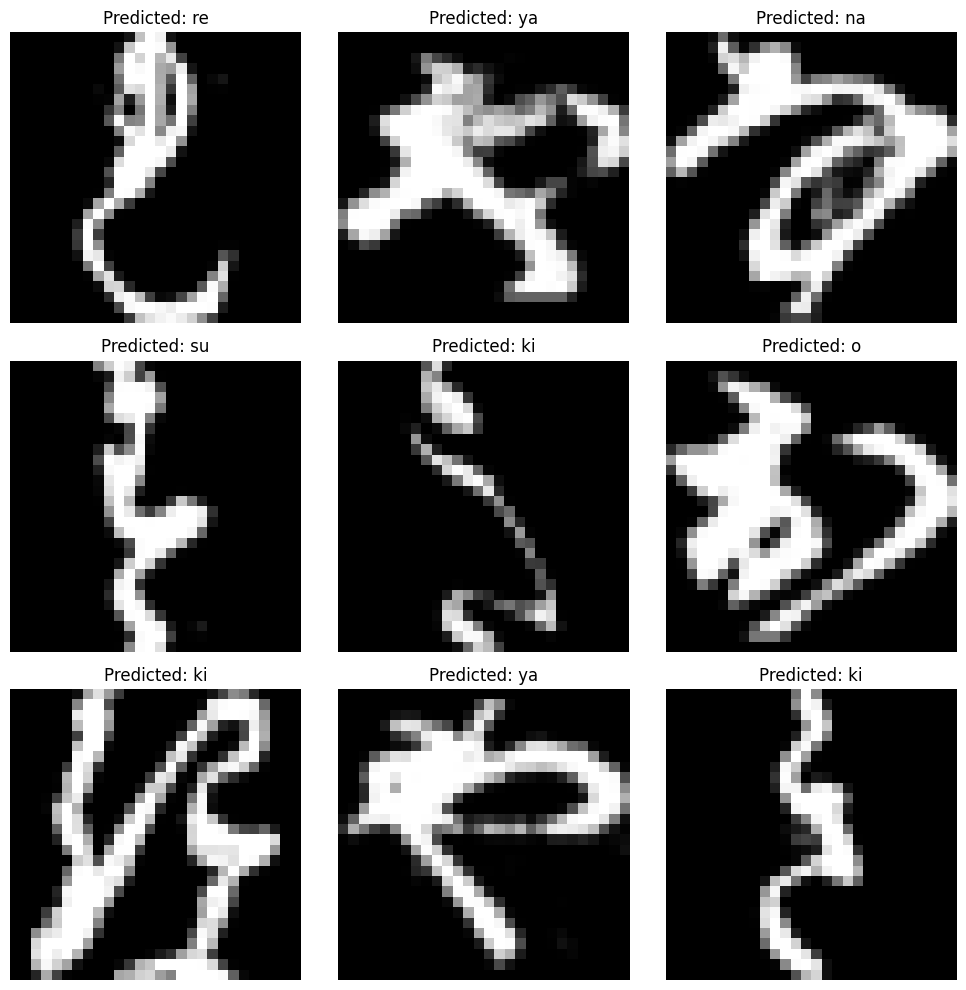

In [ ]:
#Predict & Visualize

for images, labels in test_ds.take(1):
    predictions = model_cnn.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(f"Predicted: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


#ADVANCED LEVEL — Multi-Label Classification (One-hot Fashion MNIST)

In [ ]:
!pip install tensorflow tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Load & Preprocess Fashion MNIST

# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Subsample for quick demo
# Use smaller subset to save memory clearly
x_train, y_train = x_train[:3000], y_train[:3000]
x_test, y_test = x_test[:500], y_test[:500]

# Normalize and reshape
x_train = np.expand_dims(x_train / 255.0, -1)
x_test = np.expand_dims(x_test / 255.0, -1)

# Convert to RGB & Resize
def convert_to_rgb_and_resize(images):
    images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
    return tf.image.resize(images_rgb, (224, 224))

x_train_rgb = convert_to_rgb_and_resize(x_train)
x_test_rgb = convert_to_rgb_and_resize(x_test)

# One-hot encode the labels
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
#Prepare Datasets

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train_oh)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test_oh)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Model with TF Hub (Trainable)

class CustomHubLayer(tf.keras.layers.Layer):
    def __init__(self, url, trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.url = url
        self.trainable = trainable

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.url, trainable=self.trainable)
        super().build(input_shape)

    def call(self, inputs):
        return self.hub_layer(inputs)

mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

model_multi = tf.keras.Sequential([
    CustomHubLayer(mobilenet_url, trainable=False),  # Freeze backbone
    tf.keras.layers.Dense(10, activation='sigmoid')
])


model_multi.build((None, 224, 224, 3))
model_multi.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model_multi.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_hub_layer (CustomHubLayer)    │ (None, 1001)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          10,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,020 (39.14 KB)

 Trainable params: 10,020 (39.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train & Evaluate

history = model_multi.fit(train_ds, epochs=5, validation_data=test_ds)
test_loss, test_acc = model_multi.evaluate(test_ds)
print(f"\nADVANCED LEVEL - Multi-label Test Accuracy: {test_acc:.4f}")

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.0921 - loss: 0.8005 - val_accuracy: 0.2020 - val_loss: 0.3505
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3212 - loss: 0.3122 - val_accuracy: 0.4840 - val_loss: 0.2479
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5634 - loss: 0.2295 - val_accuracy: 0.6340 - val_loss: 0.1972
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6766 - loss: 0.1821 - val_accuracy: 0.7220 - val_loss: 0.1679
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7379 - loss: 0.1593 - val_accuracy: 0.7620 - val_loss: 0.1499
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7683 - loss: 0.1517

ADVANCED LEVEL - Multi-label Test Accuracy: 0.7620


In [ ]:
history = model_multi.fit(train_ds, epochs=5, validation_data=test_ds)
test_loss, test_acc = model_multi.evaluate(test_ds)
print(f"\nADVANCED LEVEL - Multi-label Test Accuracy: {test_acc:.4f}")

Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7630 - loss: 0.1397 - val_accuracy: 0.7740 - val_loss: 0.1378
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7810 - loss: 0.1307 - val_accuracy: 0.7820 - val_loss: 0.1287
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7929 - loss: 0.1229 - val_accuracy: 0.8040 - val_loss: 0.1226
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8128 - loss: 0.1128 - val_accuracy: 0.8120 - val_loss: 0.1175
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8101 - loss: 0.1097 - val_accuracy: 0.8160 - val_loss: 0.1125
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8163 - loss: 0.1161

ADVANCED LEVEL - Multi-label Test Accuracy: 0.8160


#EXPERT LEVEL: Object Detection using TF Hub.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
# ✅ Load a built-in image from tf.keras
img_path = tf.keras.utils.get_file(
    "elephant.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg"
)

# Load and prepare the image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = tf.image.resize(img_rgb, (300, 300))
img_input = tf.expand_dims(tf.cast(img_resized, tf.uint8), axis=0)

print("✅ Image loaded and preprocessed successfully!")

✅ Image loaded and preprocessed successfully!


In [ ]:
# Load SSD MobileNet V2 detection model from TF Hub
import tensorflow_hub as hub
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")
print("✅ Object detection model loaded successfully!")

✅ Object detection model loaded successfully!


In [ ]:
# Run inference
result = detector(img_input)
result = {key: value.numpy() for key, value in result.items()}

print("\n📦 EXPERT LEVEL - Detection Results Summary:")
print("{:<25} {:<25} {:<10}".format("Output Key", "Shape", "DType"))
print("-" * 60)
for key, value in result.items():
    print("{:<25} {:<25} {:<10}".format(key, str(value.shape), str(value.dtype)))


📦 EXPERT LEVEL - Detection Results Summary:
Output Key                Shape                     DType     
------------------------------------------------------------
raw_detection_boxes       (1, 1917, 4)              float32   
detection_multiclass_scores (1, 100, 91)              float32   
detection_classes         (1, 100)                  float32   
detection_boxes           (1, 100, 4)               float32   
raw_detection_scores      (1, 1917, 91)             float32   
num_detections            (1,)                      float32   
detection_anchor_indices  (1, 100)                  float32   
detection_scores          (1, 100)                  float32   


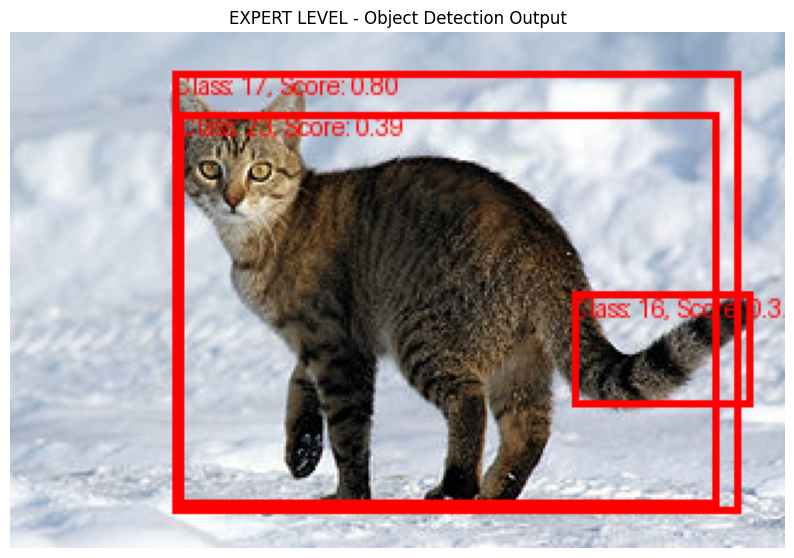

In [ ]:
#Draw Detected Boxes on the Image
from PIL import Image, ImageDraw

def draw_boxes(image, boxes, class_names, scores, max_boxes=5, min_score=0.3):
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            box = boxes[i]
            ymin, xmin, ymax, xmax = box
            im_width, im_height = image_pil.size
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.rectangle([(left, top), (right, bottom)], outline="red", width=3)
            draw.text((left, top), f"Class: {int(class_names[i])}, Score: {scores[i]:.2f}", fill="red")

    return image_pil

# Apply drawing
image_with_boxes = draw_boxes(
    img_rgb,
    result["detection_boxes"][0],
    result["detection_classes"][0],
    result["detection_scores"][0]
)

# Show output
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis("off")
plt.title("EXPERT LEVEL - Object Detection Output")
plt.show()
